Text(0.5, 1.0, '% deviation from 50 day MA')

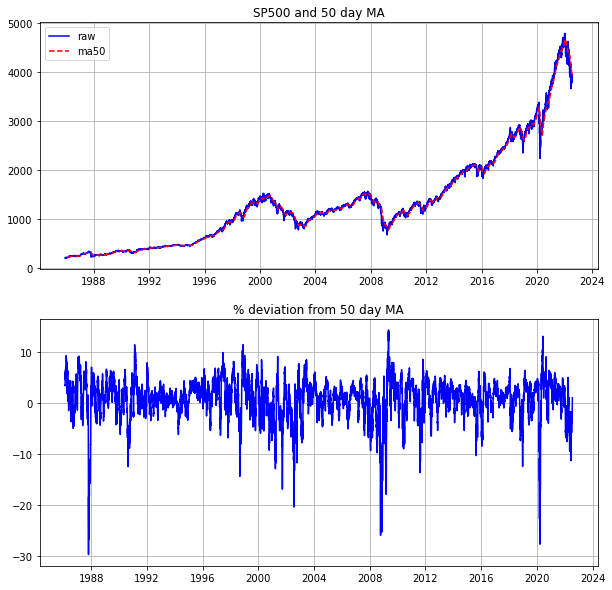

In [24]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
pd.set_option('display.max_rows', 500)


from scipy.optimize import fsolve

import yfinance as yf

#########################################
# Download SP500 index from Yahoo Finance

start_date='1985-12-01'
end_date='2022-07-21'

# download S&P500 data from yahoo
sp=yf.download('^GSPC',start=start_date,end=end_date,progress=False)
sp.head()

# calculate 50 day moving average
sp['ma50']=sp['Close'].rolling(50).mean()

plt.figure(num=1,figsize=(10,10))
plt.clf()
plt.subplot(2,1,1)
plt.plot(sp['Close'],'b-',sp['ma50'],'r--')
plt.legend(['raw','ma50'])
plt.grid('minor')
plt.title('SP500 and 50 day MA')

plt.subplot(2,1,2)
plt.plot((sp['Close']/sp['ma50']-1)*100,'b-')
plt.grid('minor')
plt.title('% deviation from 50 day MA')
#########################################



In [2]:
sp.head()

,Open,High,Low,Close,Adj Close,Volume,ma50
Date,,,,,,,
1985-12-02,202.169998,202.190002,200.199997,200.460007,200.460007,103500000,NaN
1985-12-03,200.460007,200.979996,200.100006,200.860001,200.860001,109700000,NaN
1985-12-04,200.860001,204.229996,200.860001,204.229996,204.229996,153200000,NaN
1985-12-05,204.229996,205.860001,203.789993,203.880005,203.880005,181000000,NaN
1985-12-06,203.880005,203.880005,202.449997,202.990005,202.990005,125500000,NaN


In [4]:
sp.index.min()

Timestamp('1985-12-02 00:00:00')

In [5]:
sp.index.max()

Timestamp('2022-07-20 00:00:00')

In [6]:
# calculate long-term annual average return

t1=sp.index.min()
t2=sp.index.max()
years_apart=(t2-t1)/np.timedelta64(1,'Y')
annual_avg_return=((sp.loc[t2,'Close']/sp.loc[t1,'Close'])**(1/years_apart)-1)*100

print('average annual return from ',t1,' to ',t2,' is ',annual_avg_return,'% per year')

average annual return from  1985-12-02 00:00:00  to  2022-07-20 00:00:00  is  8.485330106170586 % per year


In [7]:
# Define a function to calculate daily irr
# np financial irr cannot handle so many periods
# Here a recursive update method is used


def irr(n,w):
    # n: total number of days of income 33
    # w: total final wealth
    # i_guess: initial guess of interest rate
    
    it=0
    itmax=1e3
    di=100
    tol=1e-12
    
    i_guess=1
    while it<itmax and di>tol:
        it+=1
        i_update=(1+(1+w/33)*i_guess)**(1/(n+1))-1
        di=abs(i_update-i_guess)
        i_guess=i_update*1.0
    return i_guess


In [28]:
# Assume: $33 of daily income flowing in
# Assume: no interest rate on cash savings

# Investment Method: Wait for x% Dip then Buy with y% Savings
# Varying x and y, calculate annualized returns for all (x,y) combinations
# Investment Horizon: starting date of SP500 to today


# total number of days with income of $33/day
ND=(pd.to_datetime(sp.index[-1])-pd.to_datetime(sp.index[50])).days+1
# Note: we start from day 50 because we need to compare SP500 value with it's 50-MA

# dip1=np.linspace(-0.3,0.3,30) # values of %-dips to try
# ishare1=np.linspace(0,0.3,20) # share of saving to buy

Ndip=20
dip1=np.linspace(-0.2,0.1,Ndip) # values of %-dips to try

Nsh=20
ishare1=np.linspace(0,1,Nsh) # share of % cumulative savings invested each time

# create matrices to store results
sp_shares_bought2=np.zeros((Ndip,Nsh)) # total shares bought so far
total_wealth2=np.zeros((Ndip,Nsh)) # total wealth accumulated at end of investment period
saving2=np.zeros((Ndip,Nsh)) # total cash saving (cumulative labor income saved that is not invested in SP500)
tot_num_invest2=np.zeros((Ndip,Nsh)) # total number of times invested in SP500 (total number of dips that's large enough)

avg_daily_return2=np.zeros((Ndip,Nsh)) # average daily return for the entire investment horizon
avg_daily_return_guess=1+1e-8 # initial guess for average daily return
avg_annual_return2=np.zeros((Ndip,Nsh)) # average annual return for the entire investment horizon

print('# of dip sizes tried=',str(Ndip),'# of saving shares tried=',str(Nsh))

for i_dip,dip in enumerate(dip1): # try different %dips
    
    print('invest when SP500 dips',str(round(dip*100,0)),'% below MA(50)')

    for i_ishare,ishare in enumerate(ishare1): # try different %saving invested        
        
#         print('  invest',str(round(ishare*100,0)),'% of cumulative saving')

        t=pd.to_datetime(sp.index[50]) # start date 
        end_date=pd.to_datetime(sp.index[-1]) # end date (latest observation date)
        
        while t<=end_date: # loop over each day (not just trading days)
            
            
            # add 33 of daily income
            saving2[i_dip,i_ishare]=saving2[i_dip,i_ishare]+33
            
            
            # if trading day and stock price dips below dip, then invest
            if t in sp.index and sp.loc[t,'Close']<=sp.loc[t,'ma50']*(1-dip):
                
                tot_num_invest2[i_dip,i_ishare]+=1
                      
                
                sp_shares_bought2[i_dip,i_ishare]=sp_shares_bought2[i_dip,i_ishare]+saving2[i_dip,i_ishare]*ishare/sp.loc[t,'Close']
                
                saving2[i_dip,i_ishare]=saving2[i_dip,i_ishare]*(1-ishare)  # saving gets partially invested into stock

        
        
            t=t+dt.timedelta(days=1) 

            
        # calculate total wealth (saving+final value of SP500 shares), avg daily return
        total_wealth2[i_dip,i_ishare]=sp_shares_bought2[i_dip,i_ishare]*sp['Close'][-1]+saving2[i_dip,i_ishare]
        
        avg_daily_return2[i_dip,i_ishare]=irr(ND,total_wealth2[i_dip,i_ishare])        
        
        # calculate average annualized return (IRR)
        avg_annual_return2[i_dip,i_ishare]=(np.power((1+avg_daily_return2[i_dip,i_ishare]),365)-1)*100
        
#         print('                 Final Wealth = ',str(round(total_wealth2[i_dip,i_ishare],0)))
#         print('                 # invested in SP500 = ',str(round(tot_num_invest2[i_dip,i_ishare],0)))
#         print('                 Resulting avg annual return = ',str(round(avg_annual_return2[i_dip,i_ishare],3)),'%')
    df_temp=pd.DataFrame({'share of saving invested':np.round(ishare1*100,0),
                          'total times invested':[tot_num_invest2[i_dip,j] for j in range(len(ishare1))],
                         'avg annual return':[round(avg_annual_return2[i_dip,j],2) for j in range(len(ishare1))]})
    display(df_temp.T)
    print('')
    print('')
    




# of dip sizes tried= 20 # of saving shares tried= 20
invest when SP500 dips -20.0 % below MA(50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
share of saving invested,0.00,5.0,11.00,16.00,21.00,26.00,32.00,37.00,42.00,47.00,53.00,58.00,63.00,68.00,74.00,79.00,84.00,89.00,95.00,100.00
total times invested,9183.00,9183.0,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00
avg annual return,0.01,7.7,7.71,7.71,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72




invest when SP500 dips -18.0 % below MA(50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
share of saving invested,0.00,5.0,11.00,16.00,21.00,26.00,32.00,37.00,42.00,47.00,53.00,58.00,63.00,68.00,74.00,79.00,84.00,89.00,95.00,100.00
total times invested,9183.00,9183.0,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00
avg annual return,0.01,7.7,7.71,7.71,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72




invest when SP500 dips -17.0 % below MA(50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
share of saving invested,0.00,5.0,11.00,16.00,21.00,26.00,32.00,37.00,42.00,47.00,53.00,58.00,63.00,68.00,74.00,79.00,84.00,89.00,95.00,100.00
total times invested,9183.00,9183.0,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00
avg annual return,0.01,7.7,7.71,7.71,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72




invest when SP500 dips -15.0 % below MA(50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
share of saving invested,0.00,5.0,11.00,16.00,21.00,26.00,32.00,37.00,42.00,47.00,53.00,58.00,63.00,68.00,74.00,79.00,84.00,89.00,95.00,100.00
total times invested,9183.00,9183.0,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00,9183.00
avg annual return,0.01,7.7,7.71,7.71,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72




invest when SP500 dips -14.0 % below MA(50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
share of saving invested,0.00,5.0,11.00,16.00,21.00,26.00,32.00,37.00,42.00,47.00,53.00,58.00,63.00,68.00,74.00,79.00,84.00,89.00,95.00,100.00
total times invested,9181.00,9181.0,9181.00,9181.00,9181.00,9181.00,9181.00,9181.00,9181.00,9181.00,9181.00,9181.00,9181.00,9181.00,9181.00,9181.00,9181.00,9181.00,9181.00,9181.00
avg annual return,0.01,7.7,7.71,7.71,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72




invest when SP500 dips -12.0 % below MA(50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
share of saving invested,0.00,5.0,11.00,16.00,21.00,26.00,32.00,37.00,42.00,47.00,53.00,58.00,63.00,68.00,74.00,79.00,84.00,89.00,95.00,100.00
total times invested,9177.00,9177.0,9177.00,9177.00,9177.00,9177.00,9177.00,9177.00,9177.00,9177.00,9177.00,9177.00,9177.00,9177.00,9177.00,9177.00,9177.00,9177.00,9177.00,9177.00
avg annual return,0.01,7.7,7.71,7.71,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72




invest when SP500 dips -11.0 % below MA(50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
share of saving invested,0.00,5.0,11.00,16.00,21.00,26.00,32.00,37.00,42.00,47.00,53.00,58.00,63.00,68.00,74.00,79.00,84.00,89.00,95.00,100.00
total times invested,9165.00,9165.0,9165.00,9165.00,9165.00,9165.00,9165.00,9165.00,9165.00,9165.00,9165.00,9165.00,9165.00,9165.00,9165.00,9165.00,9165.00,9165.00,9165.00,9165.00
avg annual return,0.01,7.7,7.71,7.71,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72




invest when SP500 dips -9.0 % below MA(50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
share of saving invested,0.00,5.0,11.00,16.00,21.00,26.00,32.00,37.00,42.00,47.00,53.00,58.00,63.00,68.00,74.00,79.00,84.00,89.00,95.00,100.00
total times invested,9125.00,9125.0,9125.00,9125.00,9125.00,9125.00,9125.00,9125.00,9125.00,9125.00,9125.00,9125.00,9125.00,9125.00,9125.00,9125.00,9125.00,9125.00,9125.00,9125.00
avg annual return,0.01,7.7,7.71,7.71,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72




invest when SP500 dips -7.0 % below MA(50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
share of saving invested,0.00,5.00,11.00,16.00,21.00,26.00,32.00,37.00,42.00,47.00,53.00,58.00,63.00,68.00,74.00,79.00,84.00,89.00,95.00,100.00
total times invested,8995.00,8995.00,8995.00,8995.00,8995.00,8995.00,8995.00,8995.00,8995.00,8995.00,8995.00,8995.00,8995.00,8995.00,8995.00,8995.00,8995.00,8995.00,8995.00,8995.00
avg annual return,0.01,7.69,7.71,7.71,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72




invest when SP500 dips -6.0 % below MA(50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
share of saving invested,0.00,5.00,11.00,16.00,21.00,26.00,32.00,37.00,42.00,47.00,53.00,58.00,63.00,68.00,74.00,79.00,84.00,89.00,95.00,100.00
total times invested,8672.00,8672.00,8672.00,8672.00,8672.00,8672.00,8672.00,8672.00,8672.00,8672.00,8672.00,8672.00,8672.00,8672.00,8672.00,8672.00,8672.00,8672.00,8672.00,8672.00
avg annual return,0.01,7.69,7.71,7.71,7.71,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72




invest when SP500 dips -4.0 % below MA(50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
share of saving invested,0.00,5.00,11.00,16.00,21.00,26.00,32.00,37.00,42.00,47.00,53.00,58.00,63.00,68.00,74.00,79.00,84.00,89.00,95.00,100.00
total times invested,7871.00,7871.00,7871.00,7871.00,7871.00,7871.00,7871.00,7871.00,7871.00,7871.00,7871.00,7871.00,7871.00,7871.00,7871.00,7871.00,7871.00,7871.00,7871.00,7871.00
avg annual return,0.01,7.69,7.71,7.71,7.71,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72




invest when SP500 dips -3.0 % below MA(50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
share of saving invested,0.00,5.00,11.0,16.00,21.00,26.00,32.00,37.00,42.00,47.00,53.00,58.00,63.00,68.00,74.00,79.00,84.00,89.00,95.00,100.00
total times invested,6209.00,6209.00,6209.0,6209.00,6209.00,6209.00,6209.00,6209.00,6209.00,6209.00,6209.00,6209.00,6209.00,6209.00,6209.00,6209.00,6209.00,6209.00,6209.00,6209.00
avg annual return,0.01,7.68,7.7,7.71,7.71,7.71,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72




invest when SP500 dips -1.0 % below MA(50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
share of saving invested,0.00,5.00,11.00,16.0,21.00,26.00,32.00,37.00,42.00,47.00,53.00,58.00,63.00,68.00,74.00,79.00,84.00,89.00,95.00,100.00
total times invested,4213.00,4213.00,4213.00,4213.0,4213.00,4213.00,4213.00,4213.00,4213.00,4213.00,4213.00,4213.00,4213.00,4213.00,4213.00,4213.00,4213.00,4213.00,4213.00,4213.00
avg annual return,0.01,7.66,7.69,7.7,7.71,7.71,7.71,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72,7.72




invest when SP500 dips 1.0 % below MA(50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
share of saving invested,0.00,5.00,11.00,16.00,21.00,26.00,32.00,37.00,42.0,47.0,53.0,58.0,63.00,68.00,74.00,79.00,84.00,89.00,95.00,100.00
total times invested,2578.00,2578.00,2578.00,2578.00,2578.00,2578.00,2578.00,2578.00,2578.0,2578.0,2578.0,2578.0,2578.00,2578.00,2578.00,2578.00,2578.00,2578.00,2578.00,2578.00
avg annual return,0.01,7.61,7.65,7.67,7.68,7.68,7.69,7.69,7.7,7.7,7.7,7.7,7.71,7.71,7.71,7.71,7.71,7.71,7.71,7.71




invest when SP500 dips 2.0 % below MA(50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
share of saving invested,0.00,5.00,11.00,16.00,21.00,26.00,32.00,37.00,42.00,47.00,53.00,58.00,63.00,68.00,74.00,79.00,84.00,89.00,95.00,100.00
total times invested,1576.00,1576.00,1576.00,1576.00,1576.00,1576.00,1576.00,1576.00,1576.00,1576.00,1576.00,1576.00,1576.00,1576.00,1576.00,1576.00,1576.00,1576.00,1576.00,1576.00
avg annual return,0.01,7.53,7.62,7.64,7.66,7.66,7.67,7.67,7.67,7.68,7.68,7.68,7.68,7.68,7.68,7.68,7.68,7.68,7.69,7.69




invest when SP500 dips 4.0 % below MA(50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
share of saving invested,0.00,5.00,11.00,16.00,21.0,26.00,32.00,37.00,42.00,47.00,53.00,58.00,63.00,68.00,74.00,79.00,84.00,89.00,95.00,100.00
total times invested,934.00,934.00,934.00,934.00,934.0,934.00,934.00,934.00,934.00,934.00,934.00,934.00,934.00,934.00,934.00,934.00,934.00,934.00,934.00,934.00
avg annual return,0.01,7.21,7.39,7.46,7.5,7.52,7.53,7.54,7.54,7.55,7.55,7.55,7.56,7.56,7.56,7.56,7.56,7.56,7.56,7.56




invest when SP500 dips 5.0 % below MA(50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
share of saving invested,0.00,5.00,11.00,16.00,21.00,26.00,32.00,37.00,42.00,47.00,53.00,58.0,63.00,68.00,74.00,79.00,84.00,89.00,95.00,100.0
total times invested,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.0,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.0
avg annual return,0.01,6.88,7.05,7.11,7.16,7.19,7.22,7.24,7.26,7.28,7.29,7.3,7.32,7.33,7.34,7.35,7.36,7.37,7.39,7.4




invest when SP500 dips 7.0 % below MA(50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
share of saving invested,0.00,5.00,11.00,16.00,21.00,26.0,32.0,37.00,42.00,47.00,53.00,58.00,63.00,68.00,74.00,79.00,84.00,89.00,95.00,100.00
total times invested,345.00,345.00,345.00,345.00,345.00,345.0,345.0,345.00,345.00,345.00,345.00,345.00,345.00,345.00,345.00,345.00,345.00,345.00,345.00,345.00
avg annual return,0.01,6.61,6.82,6.89,6.91,6.9,6.9,6.89,6.88,6.88,6.87,6.87,6.86,6.86,6.86,6.86,6.86,6.86,6.87,6.87




invest when SP500 dips 8.0 % below MA(50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
share of saving invested,0.00,5.00,11.00,16.00,21.00,26.00,32.00,37.0,42.00,47.00,53.00,58.00,63.00,68.00,74.00,79.0,84.00,89.00,95.00,100.00
total times invested,223.00,223.00,223.00,223.00,223.00,223.00,223.00,223.0,223.00,223.00,223.00,223.00,223.00,223.00,223.00,223.0,223.00,223.00,223.00,223.00
avg annual return,0.01,6.31,6.54,6.67,6.77,6.83,6.87,6.9,6.92,6.92,6.93,6.93,6.92,6.92,6.91,6.9,6.89,6.89,6.88,6.87




invest when SP500 dips 10.0 % below MA(50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
share of saving invested,0.00,5.00,11.00,16.00,21.00,26.00,32.0,37.00,42.00,47.00,53.00,58.00,63.00,68.00,74.00,79.00,84.00,89.00,95.00,100.00
total times invested,168.00,168.00,168.00,168.00,168.00,168.00,168.0,168.00,168.00,168.00,168.00,168.00,168.00,168.00,168.00,168.00,168.00,168.00,168.00,168.00
avg annual return,0.01,6.28,6.48,6.58,6.66,6.74,6.8,6.85,6.89,6.92,6.95,6.96,6.98,6.99,6.99,6.99,6.99,6.99,6.99,6.98


In [29]:
df=pd.DataFrame(columns=['dip','share','sp shares bought','tot num invest','total wealth','avg daily return','avg annual return'])
for i,dip in enumerate(dip1):
    for j,share in enumerate(ishare1):
        df.loc[len(df)]=[dip,
                   share,
                   sp_shares_bought2[i][j],
                   tot_num_invest2[i][j],
                   total_wealth2[i][j],
                   avg_daily_return2[i][j],
                   avg_annual_return2[i][j]
                  ]
        


In [30]:
df

,dip,share,sp shares bought,tot num invest,total wealth,avg daily return,avg annual return
0,-0.200000,0.000000,0.000000,9183.0,4.391640e+05,1.508057e-07,0.005505
1,-0.200000,0.052632,571.210690,9183.0,2.262817e+06,2.031431e-04,7.695726
2,-0.200000,0.105263,573.189071,9183.0,2.270181e+06,2.034910e-04,7.709397
3,-0.200000,0.157895,573.862961,9183.0,2.272692e+06,2.036093e-04,7.714048
4,-0.200000,0.210526,574.203929,9183.0,2.273964e+06,2.036692e-04,7.716401
5,-0.200000,0.263158,574.410584,9183.0,2.274736e+06,2.037055e-04,7.717829
6,-0.200000,0.315789,574.550068,9183.0,2.275258e+06,2.037300e-04,7.718793
7,-0.200000,0.368421,574.651338,9183.0,2.275637e+06,2.037479e-04,7.719495
8,-0.200000,0.421053,574.728862,9183.0,2.275928e+06,2.037615e-04,7.720032
9,-0.200000,0.473684,574.790639,9183.0,2.276160e+06,2.037724e-04,7.720461


In [31]:
df.sort_values(by='avg annual return',ascending=False)

,dip,share,sp shares bought,tot num invest,total wealth,avg daily return,avg annual return
179,-0.073684,1.000000,575.197563,8995.0,2.277725e+06,2.038460e-04,7.723352
178,-0.073684,0.947368,575.175632,8995.0,2.277640e+06,2.038420e-04,7.723195
199,-0.057895,1.000000,575.159353,8672.0,2.277573e+06,2.038389e-04,7.723072
177,-0.073684,0.894737,575.151798,8995.0,2.277548e+06,2.038376e-04,7.723024
198,-0.057895,0.947368,575.136348,8672.0,2.277484e+06,2.038347e-04,7.722907
176,-0.073684,0.842105,575.125839,8995.0,2.277447e+06,2.038329e-04,7.722839
159,-0.089474,1.000000,575.120575,9125.0,2.277420e+06,2.038316e-04,7.722789
197,-0.057895,0.894737,575.111423,8672.0,2.277388e+06,2.038301e-04,7.722729
139,-0.105263,1.000000,575.106198,9165.0,2.277363e+06,2.038290e-04,7.722684
158,-0.089474,0.947368,575.103890,9125.0,2.277356e+06,2.038286e-04,7.722670


Best to wait for a -7.37 % dip in SP500 below its 50-day MA
When those dips happen, buy SP500 with 100.0 % cumulative cash saved up
Resulting annualized return = 7.72 % based on historical data.


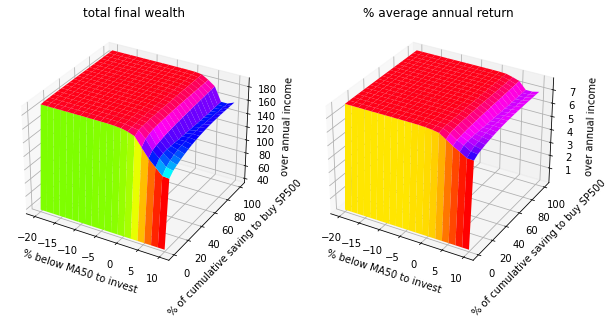

In [32]:
dip2,ishare2=np.meshgrid(dip1,ishare1,indexing='ij')

fig=plt.figure(figsize=(10,20))
plt.clf()
ax=fig.add_subplot(1,2,1,projection='3d')
ax.plot_surface(dip2*100,ishare2*100,total_wealth2/12e3,cmap=cm.hsv)
ax.set_xlabel('% below MA50 to invest')
ax.set_ylabel('% of cumulative saving to buy SP500')
ax.set_zlabel('over annual income')
ax.set_title('total final wealth')

# ax=fig.add_subplot(2,2,2,projection='3d')
# dip2,ishare2=np.meshgrid(dip1,ishare1,indexing='ij')
# ax.plot_surface(dip2*100,ishare2*100,sp_shares_bought2*sp['Close'][-1]/12e3,cmap=cm.hsv)
# ax.set_xlabel('% below MA50 to invest')
# ax.set_ylabel('% of cumulative saving to buy SP500')
# ax.set_zlabel('over annual income')
# ax.set_title('total final wealth in stock')

# ax=fig.add_subplot(2,2,3,projection='3d')
# dip2,ishare2=np.meshgrid(dip1,ishare1,indexing='ij')
# ax.plot_surface(dip2*100,ishare2*100,saving2/12e3,cmap=cm.hsv)
# ax.set_xlabel('% below MA50 to invest')
# ax.set_ylabel('% of cumulative saving to buy SP500')
# ax.set_zlabel('over annual income')
# ax.set_title('total final wealth in cash saving')

ax=fig.add_subplot(1,2,2,projection='3d')
dip2,ishare2=np.meshgrid(dip1,ishare1,indexing='ij')
ax.plot_surface(dip2*100,ishare2*100,avg_annual_return2,cmap=cm.hsv)
ax.set_xlabel('% below MA50 to invest')
ax.set_ylabel('% of cumulative saving to buy SP500')
ax.set_zlabel('over annual income')
ax.set_title('% average annual return')


# figure out best %dip and best %invest
[best_dip_idx,best_ishare_idx]=np.unravel_index(avg_annual_return2.argmax(),avg_annual_return2.shape)
print('Best to wait for a',str(round(dip1[best_dip_idx]*100,2)),'% dip in SP500 below its 50-day MA')
print('When those dips happen, buy SP500 with',str(round(ishare1[best_ishare_idx]*100,2)),'% cumulative cash saved up')
print('Resulting annualized return =',str(round(avg_annual_return2[best_dip_idx,best_ishare_idx],2)),'% based on historical data.')
                                          

# Summary:

Even if SP500 doesn't dip at all (even if dip=-10%, meaning the stock is 10% above its 50-day moving-average), invest should invest 100% of all cumulative saving.

Basically, the investor gets the highest return if they just invest 33 (all their daily income) into SP500 every day, regardless of what happens to the stock value. 

The resulting annual return is 8.43% a year.

Intuitively, "timing the market strategy" (buy-dip strategy) could work in a setup where market is more stationary. Here, growth is so fast that buy-dip strategy could lead to missed growth. Investors who wait for a large dip only get to invest very infrequently over time, while the market growth in the meanwhile is forgone. 